In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = "breast-cancer.data.csv"
dataset = pd.read_csv(file, header = None)

In [3]:
list(dataset.columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
columns = ['Class', 'age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad'
          'irradiat']
dataset.rename(columns = {i : j for i,j in zip(list(dataset.columns), columns)}, inplace = True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
Class                  286 non-null object
age                    286 non-null object
menopause              286 non-null object
tumor_size             286 non-null object
inv_nodes              286 non-null object
node_caps              286 non-null object
deg_malig              286 non-null int64
breast                 286 non-null object
breast_quadirradiat    286 non-null object
9                      286 non-null object
dtypes: int64(1), object(9)
memory usage: 22.4+ KB


In [6]:
dataset_prepared = pd.get_dummies(dataset.drop('Class', axis = 1), drop_first = True)
dataset_prepared['Class'] = dataset['Class']
dataset_prepared.head()

,deg_malig,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_lt40,menopause_premeno,tumor_size_10-14,tumor_size_15-19,...,node_caps_no,node_caps_yes,breast_right,breast_quadirradiat_central,breast_quadirradiat_left_low,breast_quadirradiat_left_up,breast_quadirradiat_right_low,breast_quadirradiat_right_up,9_yes,Class
0,3,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,no-recurrence-events
1,2,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,no-recurrence-events
2,2,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,no-recurrence-events
3,2,0,0,0,1,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,no-recurrence-events
4,2,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,no-recurrence-events


In [7]:
X = dataset_prepared.iloc[:,:-1]
y = dataset_prepared.iloc[:,-1]

In [8]:
y.value_counts()
y = y.map({"recurrence-events" : 1, "no-recurrence-events" : 0})

In [9]:
y.value_counts()

0    201
1     85
Name: Class, dtype: int64

Training a binary classification

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

#### Performance Meassure

###### Confusion Matrix

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 3)
confusion_matrix(y_train, y_train_pred)

array([[74, 90],
       [18, 46]])

Precision and Recall

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))

0.3382352941176471
0.71875


It is corrent only 33% of the time that can predict the recurrence-events class. and it only detect 71% of the recurrence-events class

F1 score

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.45999999999999996

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

<strong>Precision</strong>
 - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good.
 
 Precision = TP/TP+FP

<strong>Recall</strong>
 - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? We have got recall of 0.631 which is good for this model as it’s above 0.5.
 
 Recall = TP/TP+FN

###### Precision/Recall Trade-off

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                             method="decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

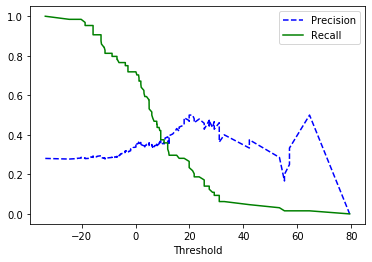

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlabel("Threshold")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
sorted(precisions)

[0.0,
 0.16666666666666666,
 0.2,
 0.25,
 0.2775330396475771,
 0.27807486631016043,
 0.27876106194690264,
 0.2798165137614679,
 0.28,
 0.2804232804232804,
 0.2807017543859649,
 0.2810810810810811,
 0.28110599078341014,
 0.28125,
 0.28125,
 0.28191489361702127,
 0.2825112107623318,
 0.2826086956521739,
 0.28272251308900526,
 0.2831050228310502,
 0.2833333333333333,
 0.2837209302325581,
 0.28378378378378377,
 0.28415300546448086,
 0.28421052631578947,
 0.2849162011173184,
 0.2849740932642487,
 0.2850467289719626,
 0.2850678733031674,
 0.2857142857142857,
 0.2857142857142857,
 0.2857142857142857,
 0.2863636363636364,
 0.2863849765258216,
 0.28640776699029125,
 0.28651685393258425,
 0.2871287128712871,
 0.287292817679558,
 0.28735632183908044,
 0.28773584905660377,
 0.28780487804878047,
 0.288135593220339,
 0.2885572139303483,
 0.28865979381443296,
 0.28901734104046245,
 0.2890995260663507,
 0.2897727272727273,
 0.29,
 0.2904761904761905,
 0.29069767441860467,
 0.29081632653061223,
 0.2914

we can see the highest precision is 1, and the second highest is 0.5

If we want to choose the thresholds with the precision 0.5

In [35]:
threshold_50_precision = thresholds[np.argmax(precisions >= 0.5)] # ~7816

In [36]:
y_train_pred_50 = (y_scores >= threshold_50_precision)

In [37]:
precision_score(y_train, y_train_pred_50)

0.5

In [38]:
recall_score(y_train, y_train_pred_50)

0.234375

A high-precision classifier is not very useful if its recall is too low!

<strong>Tip</strong>
- If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

##### The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

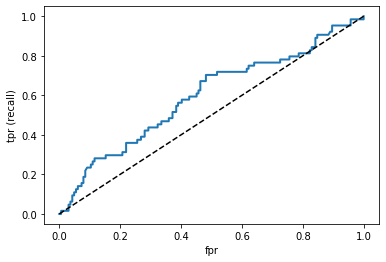

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('fpr')
    plt.ylabel('tpr (recall)')

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier;

<strong> A good classifier stays as far away from that line as possible (toward the top-left corner) </strong>

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [44]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.5958460365853658

<strong>Tip</strong>
- Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. <b>As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve </b>. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).

In [46]:
y_train.value_counts()

0    164
1     64
Name: Class, dtype: int64

Because the positif is very rare, then we might choose PR over ROC

#### Use the Random Forest Classifier

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the RandomForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other, or both. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
y_probas_forest

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.9       , 0.1       ],
       [0.2       , 0.8       ],
       [0.81      , 0.19      ],
       [0.3       , 0.7       ],
       [0.9       , 0.1       ],
       [0.3       , 0.7       ],
       [0.9       , 0.1       ],
       [0.9       , 0.1       ],
       [0.9       , 0.1       ],
       [0.8       , 0.2       ],
       [0.7       , 0.3       ],
       [0.9       , 0.1       ],
       [0.7       , 0.3       ],
       [0.9       , 0.1       ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [0.9       , 0.1       ],
       [0.7       , 0.3       ],
       [0.7       , 0.3       ],
       [1.        , 0.        ],
       [0.8       , 0.2       ],
       [0.8       , 0.2       ],
       [0.6       , 0.4       ],
       [0.8       , 0.2       ],
       [0.9       , 0.1       ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [0.7       , 0.3       ],
       [0.

The roc_curve() function expects labels and scores, but instead of scores you can give it class probabilities. Let’s use the positive class’s probability as the score:

In [51]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare (Figure 3-7):

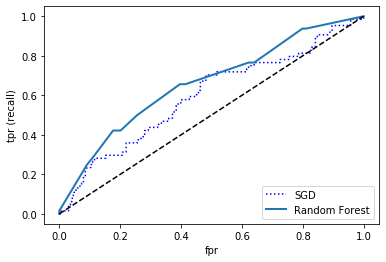

In [52]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As you can see in Figure 3-7, the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [54]:
roc_auc_score(y_train, y_scores_forest)

0.6603467987804879

In [56]:
thresholds_forest

array([2.        , 1.        , 0.9       , 0.8       , 0.7       ,
       0.6       , 0.5       , 0.48333333, 0.45      , 0.4       ,
       0.3       , 0.25      , 0.2       , 0.15      , 0.1       ,
       0.06666667, 0.        ])

In [58]:
precisions_, recalls_, thresholds_ = precision_recall_curve(y_train, y_scores_forest)

In [59]:
thresholds_

array([0.        , 0.06666667, 0.1       , 0.15      , 0.16666667,
       0.19      , 0.2       , 0.25      , 0.3       , 0.4       ,
       0.45      , 0.48333333, 0.5       , 0.6       , 0.7       ,
       0.8       , 0.9       , 1.        ])

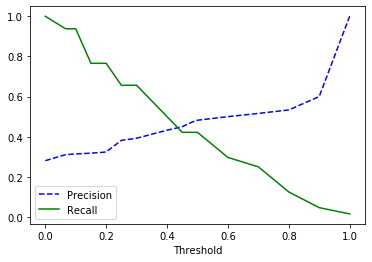

In [60]:
plot_precision_recall_vs_threshold(precisions_, recalls_, thresholds_)

### Multiclass Classification

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. <b> Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. </b> However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

In [66]:
file2 = "glass.data.csv"
glass_dataset = pd.read_csv(file2, header = None)

In [69]:
name = ['id', 'RI', 'Na', 'Mg','Al','Si','K','Ca','Ba','Fe','Class']
glass_dataset.columns = name

In [71]:
glass_dataset.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [95]:
X = glass_dataset.iloc[:,1:-1]
y = glass_dataset.iloc[:,-1]

In [96]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
scaler = StandardScaler().fit(X_train)
X_train_prepared = scaler.transform(X_train)
X_train_prepared

array([[-0.1936807 , -0.94094292,  0.6864136 , ..., -0.18247525,
        -0.35547602, -0.55580588],
       [-0.17682261, -0.30269425,  0.84654556, ..., -0.3627608 ,
        -0.35547602,  2.53861104],
       [-0.52072759, -0.25263553,  0.59590423, ..., -0.59851883,
        -0.35547602, -0.55580588],
       ...,
       [-0.44992363,  0.36058379,  0.69337586, ..., -0.75106814,
        -0.35547602, -0.55580588],
       [ 2.78345757,  0.69848015,  0.70730038, ...,  0.59413942,
        -0.35547602,  0.54934302],
       [-1.75473961, -0.54047316, -1.86873548, ..., -1.40980379,
        -0.35547602, -0.55580588]])

In [112]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train_prepared, y_train)
svm_clf.predict(X_train_prepared[0:1])

array([1])

That was easy! This code trains the SVC on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1). That’s one score per class:

In [113]:
some_digit_scores = svm_clf.decision_function(X_train_prepared[0:1])
some_digit_scores

array([[ 5.28543993,  4.25375656,  3.17327527,  0.74260547, -0.2659526 ,
         1.75225101]])

In [114]:
np.argmax(some_digit_scores)

0

In [118]:
svm_clf.classes_[0]

1

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [116]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict(X_train_prepared[0:1])

/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/

array([2])

Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

In [117]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(X_train_prepared[0:1])

array([1])

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes.

In [119]:
sgd_clf.decision_function(X_train_prepared[0:1])

array([[ 1352.76725928,   716.92046504,    89.30067013,  -310.95521485,
         -745.8204909 , -1488.82108531]])

we can see the classifier is fairly confident about its prediction : almost all scores are largerly negative,, while class 2, 3 has positive score wchich them model is highly doubt

Meassure the model performance

In [122]:
from sklearn.model_selection import cross_val_score
sgd_clf_score = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [123]:
sgd_clf_score.mean()

0.3679885383721245

The accuracy is really low

In [128]:
ovr_clf_score = cross_val_score(ovr_clf, X_train, y_train, cv = 3, scoring = 'accuracy')
ovr_clf_score.mean()

/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/

0.6619901062363149

we can see that using the RandomForest with onevsrest is better than SGD

#### Error Analysis

In [129]:
y_train_pred = cross_val_predict(ovr_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/putra/anaconda3/lib/python3.7/site-packages/sklearn/

array([[54,  7,  0,  0,  0,  0],
       [22, 30,  0,  4,  1,  0],
       [10,  2,  0,  0,  0,  0],
       [ 0,  1,  0,  9,  0,  1],
       [ 1,  2,  0,  0,  1,  3],
       [ 1,  3,  0,  0,  0, 19]])

Plot the Matrix

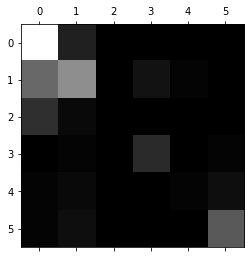

In [130]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly.